<a href="https://colab.research.google.com/github/MohamedRamadanYakoup/udacity-fbchallenge/blob/master/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
valid_size = 0.2
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
valid_idx, train_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=20, num_workers=0, sampler=valid_sampler)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=20, num_workers=0, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, num_workers=0)

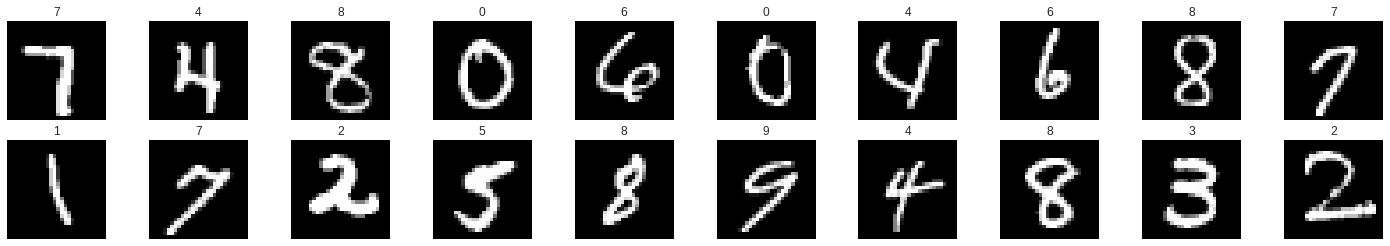

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)

images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


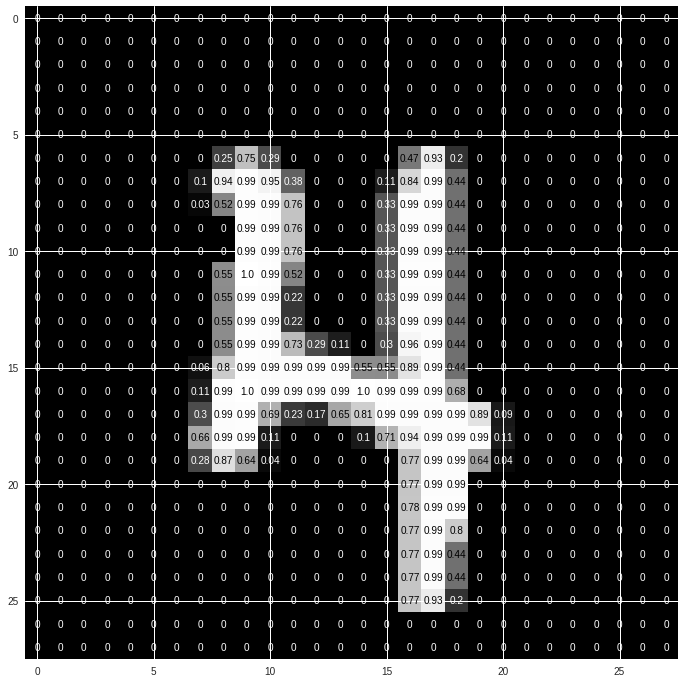

In [8]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

valid_loss_min = np.Inf

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in trainloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.736228 	Validation Loss: 0.077501
Validation loss decreased (inf --> 0.077501).  Saving model ...
Epoch: 2 	Training Loss: 0.258449 	Validation Loss: 0.059474
Validation loss decreased (0.077501 --> 0.059474).  Saving model ...
Epoch: 3 	Training Loss: 0.205560 	Validation Loss: 0.049920
Validation loss decreased (0.059474 --> 0.049920).  Saving model ...
Epoch: 4 	Training Loss: 0.170500 	Validation Loss: 0.041485
Validation loss decreased (0.049920 --> 0.041485).  Saving model ...
Epoch: 5 	Training Loss: 0.144760 	Validation Loss: 0.037279
Validation loss decreased (0.041485 --> 0.037279).  Saving model ...
Epoch: 6 	Training Loss: 0.124872 	Validation Loss: 0.032549
Validation loss decreased (0.037279 --> 0.032549).  Saving model ...
Epoch: 7 	Training Loss: 0.109156 	Validation Loss: 0.029474
Validation loss decreased (0.032549 --> 0.029474).  Saving model ...
Epoch: 8 	Training Loss: 0.096013 	Validation Loss: 0.027167
Validation loss decreased (0.02947

In [0]:
model.load_state_dict(torch.load('model.pt'))

In [13]:
# initialize lists to monitor test loss and accuracy
batch_size = 20
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.066453

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (965/982)
Test Accuracy of     5: 96% (862/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 97% (9787/10000)


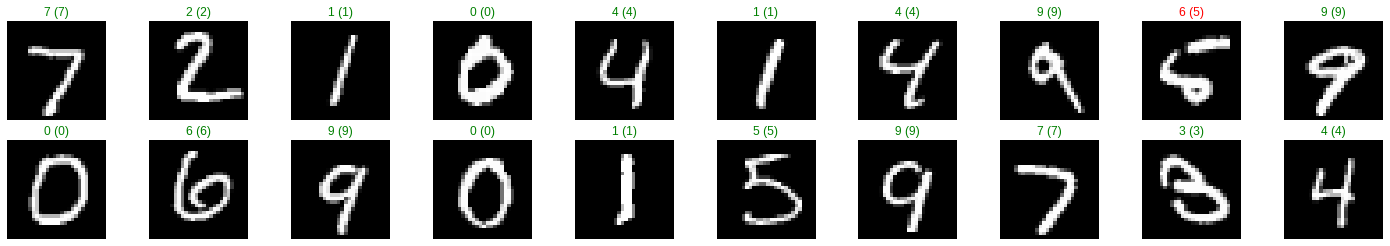

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))